In [137]:
# Pavan Mahalle 

In [139]:
# import all the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [141]:
# Download stock data from Yahoo Finance
stock_data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
stock_data.head()  # Show the first few rows


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454505,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362821,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351057,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393279,447610800


In [143]:
# Use only the 'Close' column
close_prices = stock_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)


In [145]:
# Split the data into training and testing datasets (e.g., 80% train, 20% test)
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_data_len]
test_data = scaled_data[train_data_len - 60:]

# Prepare the training data
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])  # Last 60 days
    y_train.append(train_data[i, 0])       # Target price

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM


In [147]:
# Build the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Create the Sequential model
model = Sequential()

# Add the Input layer explicitly
model.add(Input(shape=(X_train.shape[1], 1)))

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))

# Add Dense layers
model.add(Dense(units=25))
model.add(Dense(units=1))  # Final output layer for prediction

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)


2557/2557 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 5.9260e-04


In [160]:
# Create the test dataset
X_test, y_test = [], []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])  # Last 60 days

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict the prices
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse the normalization


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


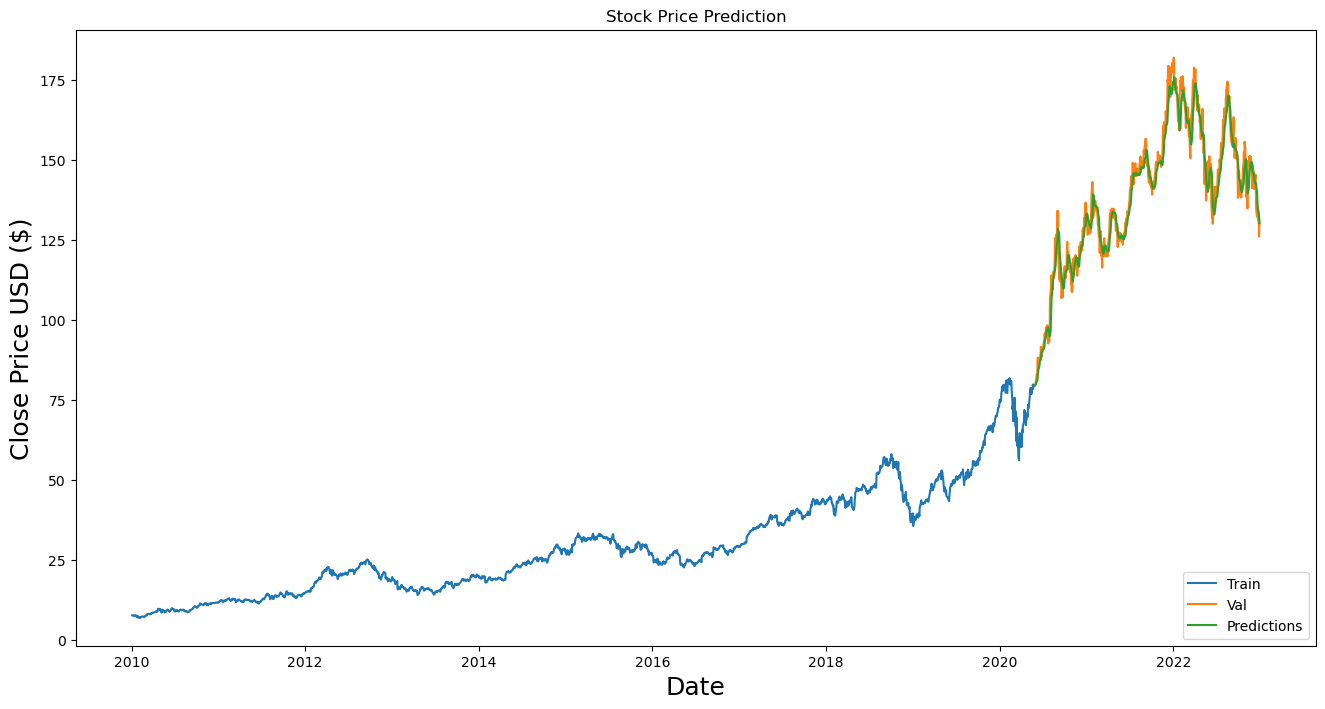

In [162]:
# Visualize the Results
train = stock_data[:train_data_len]
valid = stock_data[train_data_len:].copy()
valid.loc[:, 'Predictions'] = predictions 

# Plot the data
plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [164]:
# Evaluate the Model
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(valid['Close'], predictions))
print(f'RMSE: {rmse}')
# RMSE gives you an idea of how far off the predictions are from actual values (lower is better).

RMSE: 4.394069468098869


In [168]:
# Set a fixed USD to INR conversion rate
usd_to_inr = 83  # Replace with your desired conversion rate

# Assuming train and valid DataFrames already exist with 'Close' and 'Predictions' columns
train.loc[:, 'Close_INR'] = train['Close'] * usd_to_inr
valid.loc[:, 'Close_INR'] = valid['Close'] * usd_to_inr
valid.loc[:, 'Predictions_INR'] = valid['Predictions'] * usd_to_inr


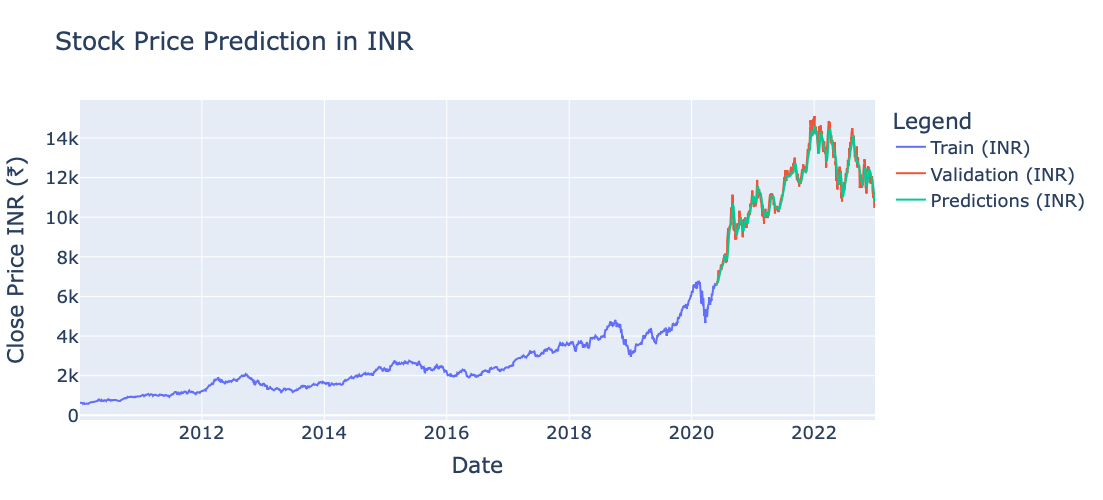

In [172]:
# Update the Result in Interactive Plot to Show Prices in INR
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create a subplot
fig = make_subplots()

# Add traces for the training data, validation data, and predictions in INR
fig.add_trace(go.Scatter(x=train.index, y=train['Close_INR'], mode='lines', name='Train (INR)'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Close_INR'], mode='lines', name='Validation (INR)'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Predictions_INR'], mode='lines', name='Predictions (INR)'))

# Update layout for titles and labels
fig.update_layout(
    title='Stock Price Prediction in INR',
    xaxis_title='Date',
    yaxis_title='Close Price INR (₹)',
    legend_title='Legend',
    font=dict(size=18),
    width=1100,
    height=500
)

# Show the interactive plot
fig.show()
